# **01. Intro to Stable Diffusion**

## **What is Stable Diffusion?**

Stable Diffusion is a deep learning model that generates images from text using a process called diffusion. It gradually transforms random noise into a coherent image by following the guidance of the input prompt.

## **How Do Diffusion Models Work?**

**The process they follow includes:**
* Starting with a real data sample.
* Corrupting the data by gradually adding Gaussian noise until the data is pure noise.
* Reversing the noise-adding process until a coherent, but new, data sample is create

**Diffusion Process**

* Forward Process: Adds noise to the image iteratively.
* Reverse Process: Gradually removes noise to refine the image based on text guidance.

**Main Components of Diffusion Models**

**1.Autoencoder (VAE)**
* Encoder: Compresses the image into a latent representation.
* Decoder: Converts the latent representation back into the image. During inference, only the decoder is used.

**2.U-Net**
* Consists of encoder and decoder parts using ResNet blocks.
* Encoder: Compresses the image to a lower resolution.
* Decoder: Converts the image back to a high resolution, predicting noise residuals to compute the denoised image.

**3.Text-Encoder**
* Transforms the text prompt into an embedding space that the U-Net can interpret.


## **Applications of diffusion**

1. **Image Generation:** Create new images from text descriptions.

1. **Text-to-Image:** Generate images based on written prompts.

1. **Image Enhancement:** Improve image quality and fill in missing parts.

# **02. About Dataset**
The structure of our data is as follows:

* **prompts:** csv dataset containing the text that was used to generate the images
* **sample_submission:** csv file containing a sample of how the submission should look like
* **images:** All the images generated

# **03. Import Libraries**

In [1]:
# General Libraries
import os
import re
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import itertools
import warnings

# Visualization Libraries
import seaborn as sns
import matplotlib.patches as patches
from IPython.display import display_html

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# **04. Load the dataset**

In [2]:
prompts = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")

In [3]:
B = '\033[38;5;153m' 
BLUE = '#00008B'
RESET = '\033[0m'  

# Print the shape of the dataset
print(f"{B}Shape of train example: {prompts.shape}{RESET}")

# Print the prompt texts
print(f"{B} Prompt's text: {RESET}")
for k, txt in enumerate(prompts.prompt):
    print(f"{B}{k}.{RESET} {txt}")
    
prompts.head()


Shape of train example: (7, 2)
 Prompt's text: 
0. hyper realistic photo of very friendly and dystopian crater
1. ramen carved out of fractal rose ebony, in the style of hudson river school
2. ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus
3. a thundering retro robot crane inks on parchment with a droopy french bulldog
4. portrait painting of a shimmering greek hero, next to a loud frill-necked lizard
5. an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms
6. Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims "Donuts. It's what's for dinner!"


imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...

# **05. Display Images**

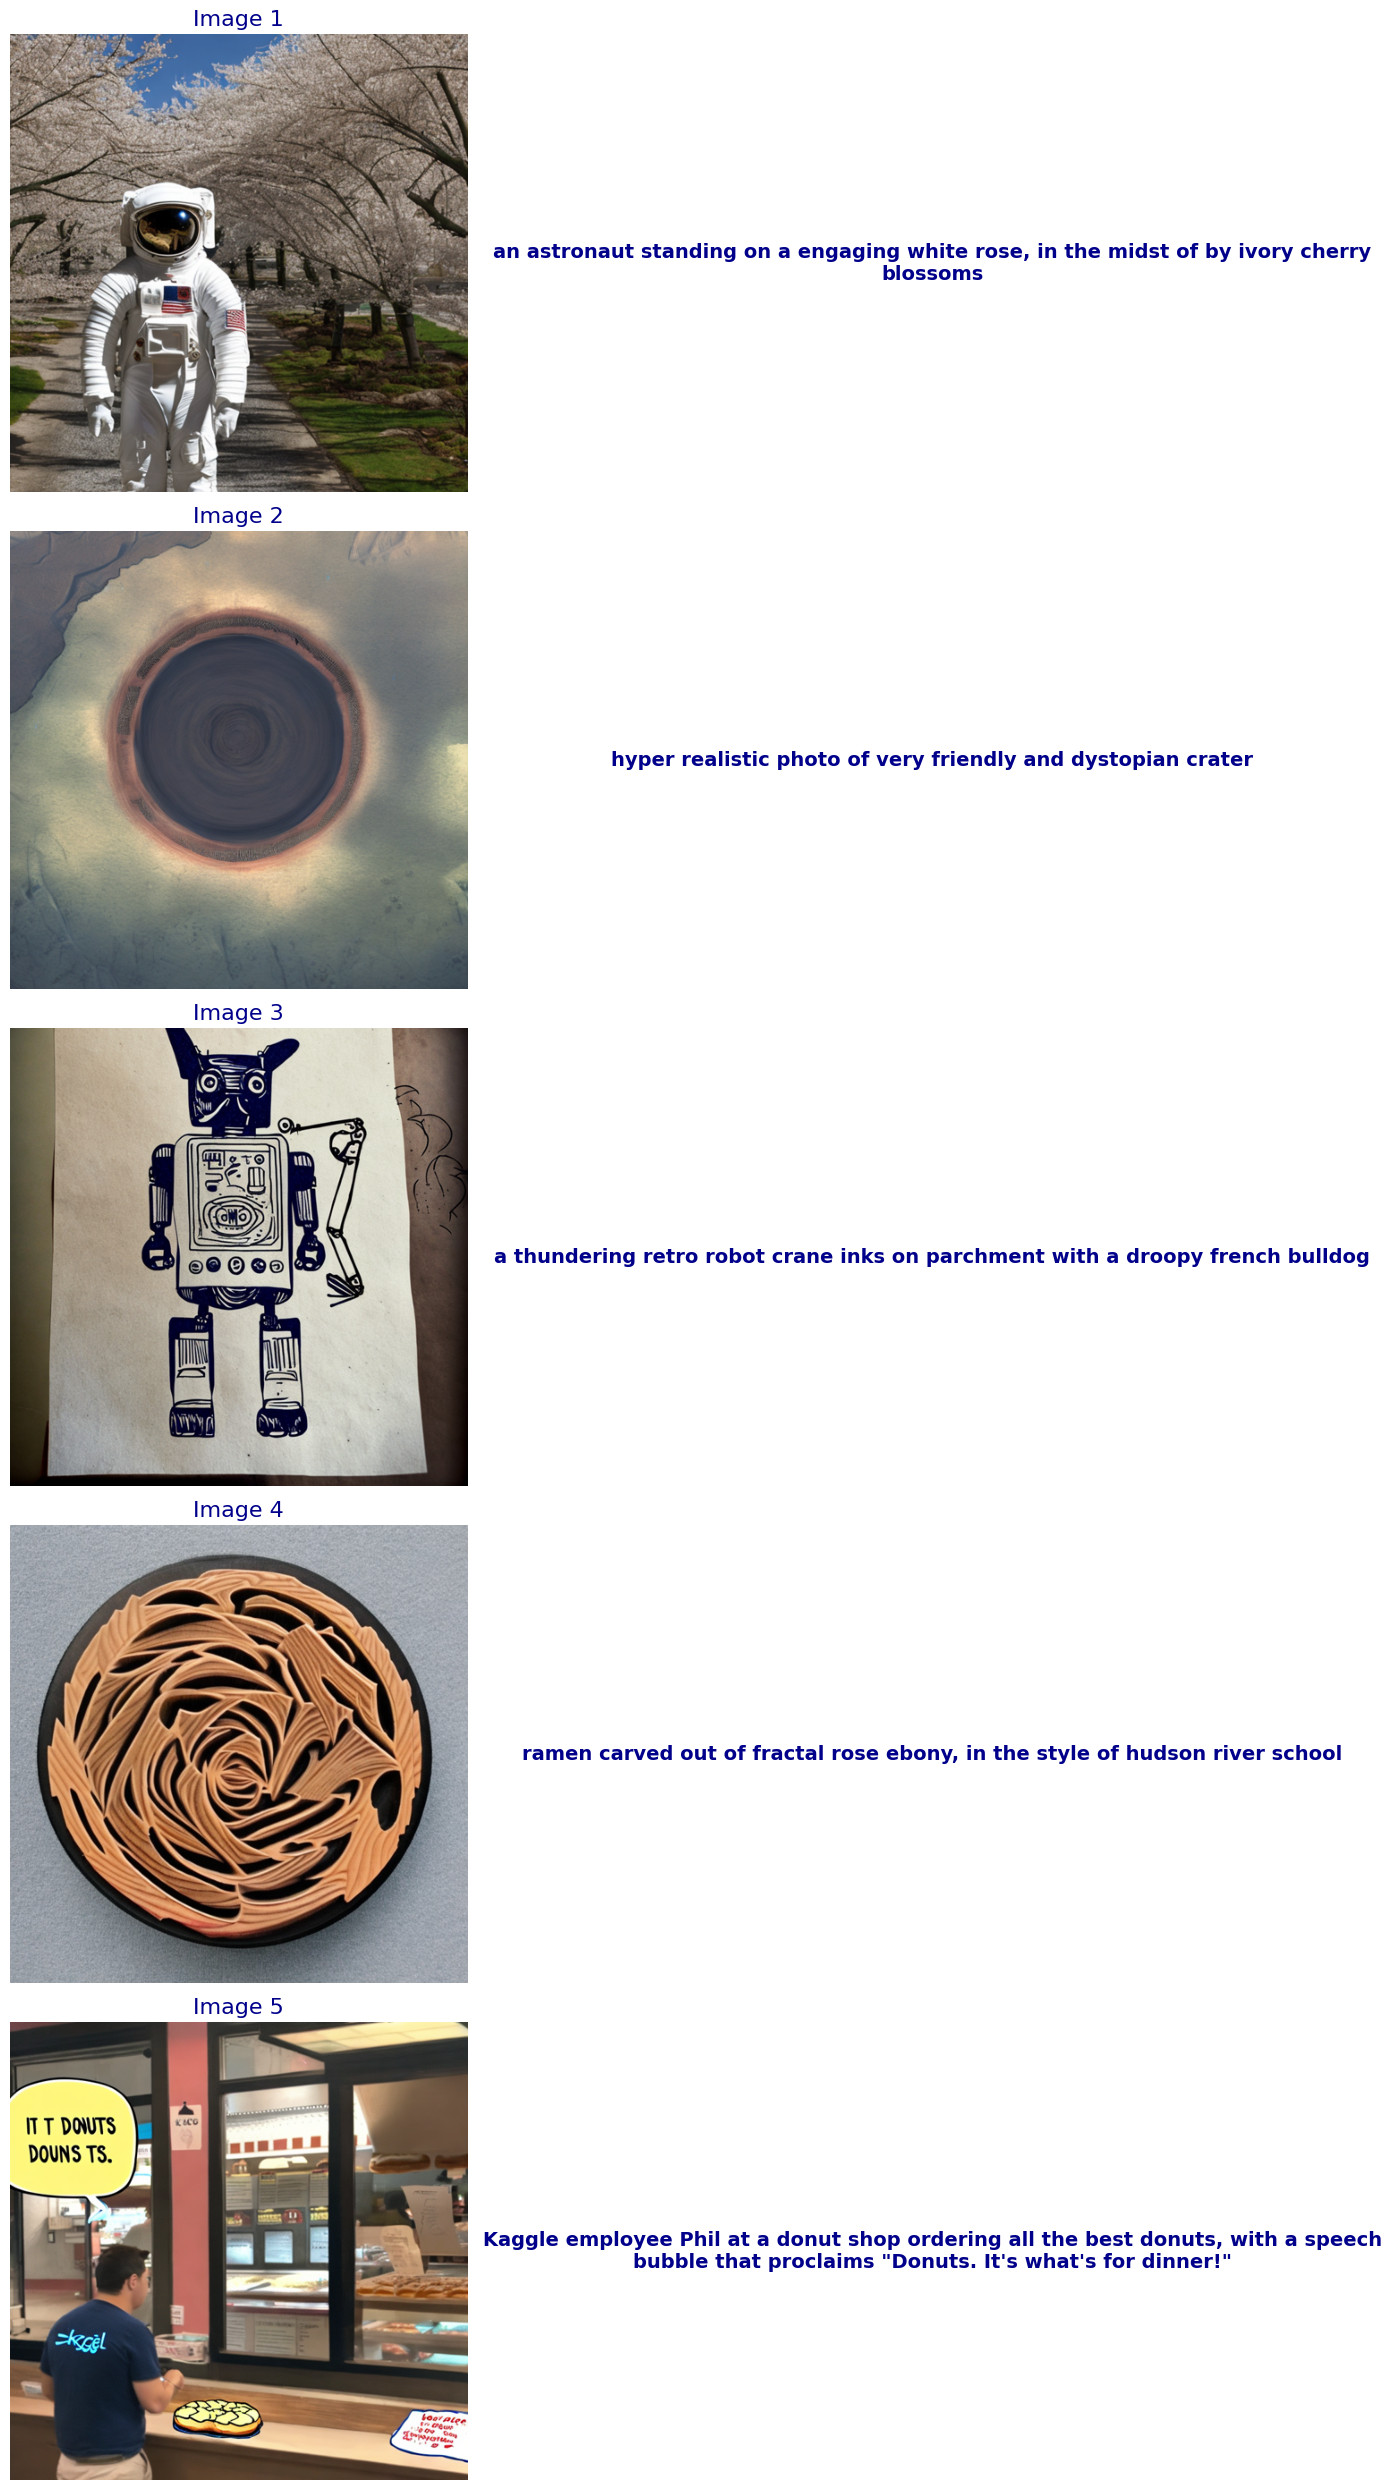

In [4]:
def show_random_images(prompts, num_samples=5):
    """
    Display random images and their associated prompts.

    Parameters:
    - prompts: DataFrame containing image IDs and prompts.
    - num_samples: Number of random samples to display.
    """
    
    sample_indices = random.sample(range(len(prompts)), num_samples)
    sample_data = prompts.iloc[sample_indices]
    
   
    fig, axs = plt.subplots(num_samples, 2, figsize=(15, num_samples * 5))
    path = "/kaggle/input/stable-diffusion-image-to-prompts/images/"
    
    # Plot each sample
    for i, (_, row) in enumerate(sample_data.iterrows()):
        # Image path
        image_path = f"{path}{row['imgId']}.png"
        img = plt.imread(image_path)
        
        # Plot Image
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Image {i + 1}", fontsize=16, color=BLUE)
        
         # Plot Text
        axs[i, 1].text(0.5, 0.5, row["prompt"], ha='center', va='center', fontsize=14, color=BLUE, wrap=True, weight='bold')
        axs[i, 1].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
show_random_images(prompts, num_samples=5)


# **06. Install Dependencies**

In [5]:
!pip install diffusers==0.11.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 10.9 MB/s eta 0:00:00


In [6]:
!pip install transformers scipy ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [7]:
pip install jax==0.4.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for jax: filename=jax-0.4.10-py3-none-any.whl size=1480499 sha256=249393eb5eabc62f5dcb642600c0669e1475064087b147d3664c3dfe8e575ee7
  Stored in directory: /root/.cache/pip/wheels/2f/04/51/ebc9c5225f0a0df1e56c231c1f4c9b7afd3e024ebb492eed99
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires jax>=0.4.16, but you have jax 0.4.10 which is incompatible.
flax 0.8.4 requires jax>=0.4.19, but you have jax 0.4.10 which is incompatible.
or

In [8]:
!pip install --upgrade diffusers
!pip install --upgrade jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26.dev20240620
    Uninstalling jaxlib-0.4.26.dev20240620:
      Successfully uninstalled jaxlib-0.4.26.dev20240620
  Attempting uninstall: jax
    Found existing installation: jax 0.4.10
    Uninstalling jax-0.4.10:
      Successfully uninstalled jax-0.4.10


In [9]:
import jax
import jaxlib

print(jax.__version__)
print(jaxlib.__version__)


0.4.34
0.4.34


# **07. Initialize Pipeline**

In [10]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 
# Move pipeline to GPU
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# **08. Image Generation**

In [11]:
def image_grid(imgs, rows, cols):
    "src: https://huggingface.co/blog/stable_diffusion"
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

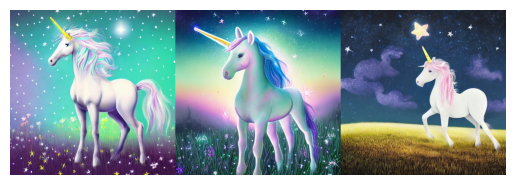

In [12]:
N = 3
prompt = ["An ethereal unicorn grazing in a moonlit meadow, surrounded by twinkling stars."] * N

# Generate images
images = pipe(prompt).images

# Display images in a grid
grid = image_grid(images, rows=1, cols=3)
plt.imshow(grid)
plt.axis("off")
plt.show()

# **09. Load Additional Dataset**

In [13]:
# Load the dataset
from datasets import load_dataset
dataset = load_dataset("Gustavosta/Stable-Diffusion-Prompts")

README.md:   0%|          | 0.00/777 [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/9.23M [00:00<?, ?B/s]

eval.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73718 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8192 [00:00<?, ? examples/s]

In [14]:
# Check the overall dimension
print(f"{B} Length of Train data:{RESET}", len(dataset["train"]["Prompt"]))
print(f"{B} Length of Test data:{RESET}", len(dataset["test"]["Prompt"]))

 Length of Train data: 73718
 Length of Test data: 8192


In [15]:
# Get prompts into a dataframe
train = pd.DataFrame(dataset["train"]["Prompt"], columns=["prompt"])
test = pd.DataFrame(dataset["test"]["Prompt"], columns=["prompt"])

df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Save df
df.to_parquet("stable_diffusion_prompts.parquet", index=False)

df.head()

prompt
0  realistic car 3 d render sci - fi car and sci ...
1  a comic potrait of a female necromamcer with b...
2  steampunk market interior, colorful, 3 d scene...
3  “A portrait of a cyborg in a golden suit, D&D ...
4  A full portrait of a beautiful post apocalypti...

Prompt: ✨🕌🌙, Art Deco, in socotra island, Trending artstation, octane render, surrealist, cinematic, shadow of the tomb rider


  0%|          | 0/50 [00:00<?, ?it/s]

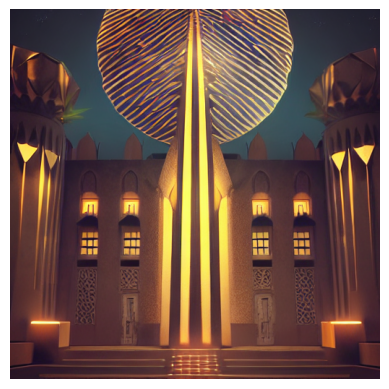

Prompt: massive starship in the shape of a spear traveling through space by paul chadeisson, concept art, scifi, 4 k, digital ilustration, artstation hq


  0%|          | 0/50 [00:00<?, ?it/s]

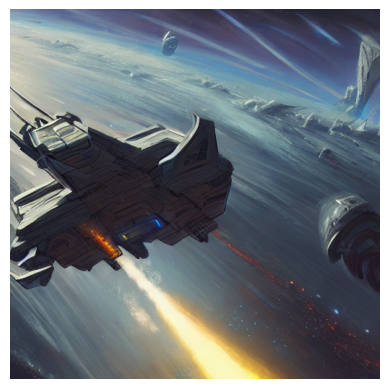

Prompt: cabin high on a mountain, the valley beneath, dynamic lighting, photorealistic fantasy concept art, trending on art station, stunning visuals, creative, cinematic, ultra detailed


  0%|          | 0/50 [00:00<?, ?it/s]

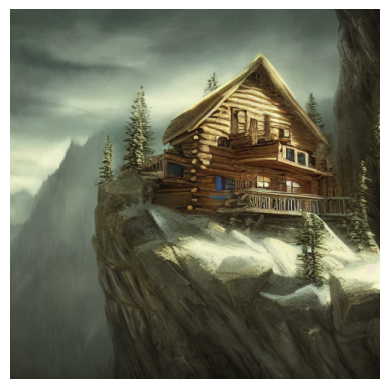

Prompt: portrait of a man by greg rutkowski, he looks like tye sheridan, he is about 2 0 years old, messy brown hair, tired eyes, he is wearing a black hoodie with hood, highly detailed portrait, digital painting, artstation, concept art, smooth, sharp foccus ilustration, artstation hq


  0%|          | 0/50 [00:00<?, ?it/s]

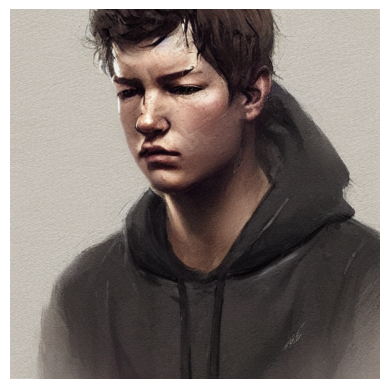

Prompt: highly detailed photo of five colorful jellyfish floating in dark under water sea, hyper realistic, concept art, 8 k detail post - processing


  0%|          | 0/50 [00:00<?, ?it/s]

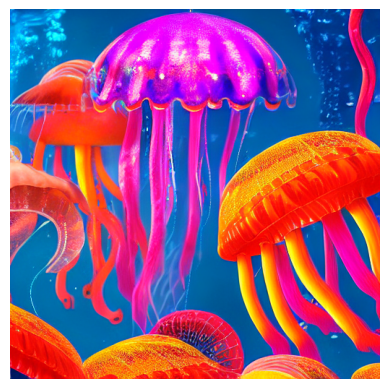

In [16]:
idxs = [124, 780,75449, 39920,356]

for prompt in df.filter(items=idxs, axis=0)["prompt"]:
    print("Prompt:", prompt)
    image = pipe(prompt).images[0]
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# **10. Now, You can generate your Image**

  0%|          | 0/50 [00:00<?, ?it/s]

Your Image:


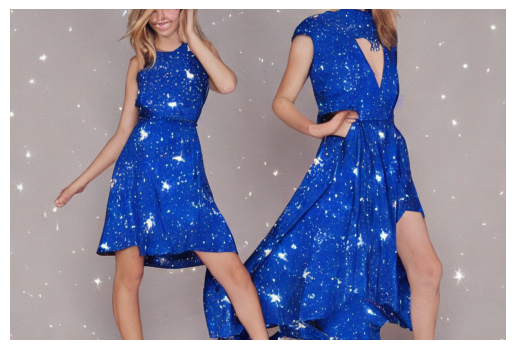

In [17]:
# Define your text for image generation
user_text = "modal wearing blue dress surronded by twinkling stars,dynamic lighting under a colorful galaxy."

# Generate the image based on the predefined text
image = pipe(user_text, height=512, width=768).images[0]

# Display the image
print("Your Image:")
plt.imshow(image)
plt.axis("off")
plt.show()